In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import os
import numpy as np
import yaml
import matplotlib.pyplot as plt
import torchaudio
from ltng.ae import VoiceAutoEncoder
from IPython.display import Audio
import librosa
from librosa.display import specshow
from pathlib import Path
from itertools import starmap
from copy import deepcopy
import diffsptk
import pysptk

from test_rtf import dict2object, get_instance
from models.audiotensor import AudioTensor
from models.utils import fir_filt


In [2]:
ckpt_path = "/home/alenhardt/src/github.com/golf/GOLF-ae/3nixdul5/checkpoints/pokey-epoch=157-step=72364-val_loss=3.250.ckpt"
cfg_path = Path(ckpt_path).parent.parent / "config.yaml"
test_file = (
    "/mnt/wsl/PhysicalDrive3p1/datasets/LibriMix_data/LibriSpeech/golf_dev/1919/142785/1919-142785-0007.wav"
)
test_f0 = Path(test_file).with_suffix(".pv")

In [3]:
def load_config(config_path):
    with open(config_path) as f:
        config = yaml.safe_load(f)
    return (
        config["model"]["init_args"]
        if "class_path" in config["model"]
        else config["model"]
    )


def load_model(ckpt_path, config):
    model = VoiceAutoEncoder.load_from_checkpoint(
        ckpt_path, map_location="cpu", strict=True, **dict2object(config)
    ).cpu()
    model.eval()
    return model


cfg = load_config(cfg_path)
print(cfg)

model = load_model(ckpt_path=ckpt_path, config=cfg)


{'decoder': {'class_path': 'models.sf.SourceFilterSynth', 'init_args': {'harm_oscillator': {'class_path': 'models.synth.DownsampledIndexedGlottalFlowTable', 'init_args': {'hop_rate': 10, 'in_channels': 64, 'oversampling': 4, 'equal_energy': True, 'table_size': 100, 'table_type': 'derivative', 'normalize_method': 'constant_power', 'align_peak': True, 'trainable': False, 'min_R_d': 0.3, 'max_R_d': 2.7, 'lf_v2': True, 'points': 2048}}, 'noise_generator': {'class_path': 'models.noise.StandardNormalNoise'}, 'noise_filter': {'class_path': 'models.filters.LTVZeroPhaseFIRFilter', 'init_args': {'window': 'hanning', 'conv_method': 'direct', 'n_mag': 256}}, 'end_filter': {'class_path': 'models.filters.LTVMinimumPhaseFilter', 'init_args': {'window': 'hanning', 'window_length': 960, 'centred': True, 'lpc_order': 22, 'lpc_parameterisation': 'rc2lpc', 'max_abs_value': 1.0}}, 'room_filter': {'class_path': 'models.filters.LTIAcousticFilter', 'init_args': {'length': 128, 'conv_method': 'fft'}}, 'subtrac

0.0 316.003527
(5326,)
torch.Size([630000])
(630000,)


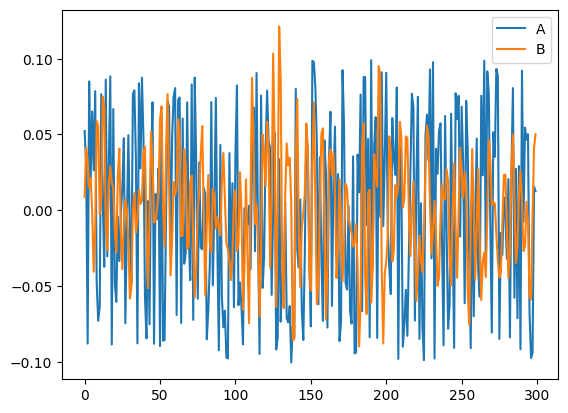

In [75]:
x, sr = torchaudio.load(test_file)
# x = x[0]
x = x[0] + F.tanh(torch.randn(x[0].shape[0]))*0.1
f0 = np.loadtxt(test_f0)
print(f0.min(), f0.max())
f0_mod_depth = 0
f0_base = 180
f0_mod_freq = 2.0
t = np.linspace(0, x.shape[0] / float(sr), f0.shape[0])
#f0 = np.sin(2 * np.pi * t * f0_mod_freq) * f0_mod_depth +  f0_base
print(f0.shape)

f0_infer = AudioTensor(torch.from_numpy(f0).float().unsqueeze(0), hop_length=120)
x_infer = AudioTensor(x.unsqueeze(0), hop_length=1)
params = {"phase": torch.where(f0_infer > 0, f0_infer, 150) / sr}


@torch.no_grad()
def recon(model):
    return model(x_infer, f0_infer, params)


rec, *other = recon(model)

# plt.plot(f0)
# plt.show()
pa = 30000 + 80
pb = pa + 300
lag = 120

plt.plot(x.squeeze()[pa:pb])
plt.plot(rec.squeeze()[lag + pa:lag + pb])
plt.legend(['A', 'B'])
# plt.show()


x_trunc = x[:630000]
rec_trunc = rec.squeeze()[:630000]
noisy_orig = x_trunc + np.tanh(np.random.randn(x_trunc.shape[0]))*0.0
print(noisy_orig.shape)
print(rec_trunc.shape)
a1 = Audio(noisy_orig, rate=sr)
a2 = Audio(noisy_orig + rec_trunc*14, rate=sr)
display(a1)
display(a2)